# <b>ENGR 418 Project Stage 2</b>

<b>Group 7 <br>
Group Members:</b> <br>
Alif Aiman Ahmad Zukiman | 35338490 <br>
Anas Chellabi | 86925930

_December 13, 2023_

## Problem Description
This is a continuation of the previous stage of the project, where we were tasked to design a multi-class classifier in classifying 4 different Legos. 

Now, instead of having all the Legos centered and oriented in a certain way, this time the data to be fed contains Legos with all kinds of positioning and orientation, which adds another degree to the difficulty. We are also requireed to use only 64 features (8x8 pixels per image), instead of 4096 features (64x64 pixels per image) as in stage 1. This implies the use of feature engineering and selection, as well as possibly dimension reduction before applying the regressor.  

<b>Note:</b> Steps 1-4 follow the previous stage in order to be able to test the old model onto the new dataset.

### 1. Data Extraction

Import necessary libraries:

In [1791]:
import os                                                      
import numpy as np  
from numpy import asarray
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.linear_model import LogisticRegression             
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from PIL import Image, ImageFilter   
from scipy import ndimage   
from scipy import signal                              
import random  

User-defined paths:

In [1642]:
# dataset file path for Alif
training_path = "F:\\EDU UBC\\Assignments\\ENGR 418 (MCHL)\\Data\\Lego_dataset_2\\training\\" 
testing_path = "F:\\EDU UBC\\Assignments\\ENGR 418 (MCHL)\\Data\\Lego_dataset_2\\testing\\"

# dataset file path for Anas
# training_path = "e:\\418 dataset\\Lego_dataset_1\\training\\" 
# testing_path = "e:\\418 dataset\\Lego_dataset_1\\testing\\"

Assign arrays of training and testing by redirecting the arrays to the specified paths:

In [1643]:
n_classes = 4   # no. of classes

# create empty lists for four classes
folder_training = []

# detect how many files we have per class
# class 0:"2b1", class 1:"cir", class 2:"rec", class 3:"squ"
classes = [i for i in range(n_classes)]
class_type = ["2x1", "cir", "rec", "squ"]

# routine for storing folder_training with paths for each image
for i in range(len(class_type)):

    class_temp = [] # list to temporarily store class in consideration

    # run through the entire training dataset and detect if it is of the same type as
    # one we are considering. if true, then put into class_temp
    for j in os.listdir(training_path):
        if class_type[i] in j:
            class_temp.append(j)
    
    folder_training.append(class_temp)

for i in range(len(folder_training)):
    for j in range(len(folder_training[i])):
        folder_elem = folder_training[i][j]
        folder_training[i][j] = training_path + folder_elem

# print(folder_training)
# print(len(folder_training))

Define a function "get_data" to retrieve information about the chosen images:

In [1644]:
def get_data(folder, im_width, label, n_samples):

    # x,y coordinates for storing the image pixels
    x = np.empty((n_samples, im_width**2))
    y = np.empty((n_samples, 1))

    # extract image information into x,y
    for i in range(n_samples):
        path = folder[i]
        im = Image.open(path).convert('L')  # open image and convert to grayscale
        im = im.resize((im_width,im_width)) # resize to pixel size desired
        im_array = asarray(im)
        x[i,:] = im_array.reshape(1,-1)
        y[i,0] = classes[label]

    return x,y

### 2. Parameter Initialization and Training Data Preparation

In [1668]:
im_width = 200   # pixel size to be considered
P_per_class = [len(folder_training[i]) for i in range(n_classes)]
x_train = np.empty((sum(P_per_class), im_width**2))
y_train = np.empty((sum(P_per_class), 1))

for i in range(n_classes):
    x_i, y_i = get_data(folder_training[i], im_width, i, P_per_class[i])
    x_train[i*P_per_class[i] : (i+1)*P_per_class[i],:] = x_i
    y_train[i*P_per_class[i] : (i+1)*P_per_class[i],:] = y_i

print(x_train.shape, y_train.shape)

(108, 40000) (108, 1)


Check to see if the get_data function was working properly:

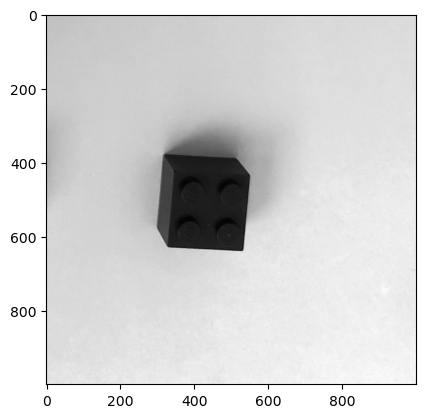

In [1646]:
i_check = random.randrange(n_classes)
j_check = random.randrange(P_per_class[i_check])
res_check = 1000

x_check, y_check = get_data(folder_training[i_check], res_check, i_check, P_per_class[i_check])
plt.imshow(x_check[j_check,:].reshape(res_check,res_check), cmap = 'gray')
plt.show()

### 3. Model Training

In [1647]:
# Logistic Regression Modelling
# we limit the iteration number to 1500 to avoid the system raise warnings in the output
# y_train has an added parameter (i.e. .ravel()) to also avoid the same thing above

model = LogisticRegression()
model.fit(x_train,y_train.ravel())

c:\Users\Alif Aiman\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### 4. Accuracy Test on Old Model

Define a function "test_function":

In [1648]:
def test_function(path):

    # store array of directories to each image sorted to their defined classes in the path
    folder_path = []

    for i in range(len(class_type)):

        class_temp = []

        for j in os.listdir(path):
            if class_type[i] in j:
                class_temp.append(j)
                
        folder_path.append(class_temp)

    for i in range(len(folder_path)):
        for j in range(len(folder_path[i])):
            folder_elem = folder_path[i][j]
            folder_path[i][j] = path + folder_elem

    # prepare data for testing
    P_per_class = [len(folder_path[i]) for i in range(n_classes)]
    x_test = np.empty((sum(P_per_class), im_width**2))
    y_test = np.empty((sum(P_per_class), 1))

    for i in range(n_classes):
        x_i, y_i = get_data(folder_path[i], im_width, i, P_per_class[i])
        x_test[i*P_per_class[i]:(i+1)*P_per_class[i],:] = x_i
        y_test[i*P_per_class[i]:(i+1)*P_per_class[i],:] = y_i

    # test model
    y_pred = model.predict(x_test)
    print(f"Confusion matrix: \n{confusion_matrix(y_test,y_pred)}")
    print(f"Accuracy score: {accuracy_score(y_test,y_pred):.3f}")

Test accuracy on new dataset:</br>
As seen below, with the old model (with only 64 features maximum), we are only able to achieve less than 50% accuracy.

In [1649]:
path = testing_path
test_function(path)

Confusion matrix: 
[[11  7  6  3]
 [ 4 13  4  6]
 [ 2  1 23  1]
 [ 2 10  7  8]]
Accuracy score: 0.509


### 5. Feature Engineering

In [1650]:
def calculate_moments(array):
    # Calculate image moments for orientation analysis
    rows, cols = array.shape
    y, x = np.mgrid[:rows, :cols]

    moments = {}
    moments['m00'] = np.sum(array)
    moments['m10'] = np.sum(x * array)
    moments['m01'] = np.sum(y * array)
    moments['mu11'] = np.sum((y - moments['m01'] / moments['m00']) * (x - moments['m10'] / moments['m00']) * array)
    moments['mu20'] = np.sum((x - moments['m10'] / moments['m00']) ** 2 * array)
    moments['mu02'] = np.sum((y - moments['m01'] / moments['m00']) ** 2 * array)

    return moments

In [1651]:
def clean_up(array, neighbour_thresh):
    kernel_size = int(array.shape[0]/10)

    # vertical sweep
    for i in range(0,array.shape[0],kernel_size):
        kernel = array[i:i+kernel_size,:]
        count = len(kernel[kernel > 0])

        if count < neighbour_thresh:
            array[i:i+kernel_size,:] = 0

    # horizontal sweep
    for j in range(0,array.shape[1],kernel_size):
        kernel = array[:, j:j+kernel_size]
        count = len(kernel[kernel > 0])

        if count < neighbour_thresh:
            array[:, j:j+kernel_size] = 0

    # patch sweep
    kernel_size = int(array.shape[0]/10)

    for i in range(0,array.shape[0],kernel_size):
        for j in range(0,array.shape[1], kernel_size):
            kernel = array[i:i+kernel_size, j:j+kernel_size]
            count = len(kernel[kernel > 0])
            
            if count < neighbour_thresh:
                array[i:i+kernel_size, j:j+kernel_size] = 0

    return array

In [1933]:
def crop(array):
    # collects all the indices that have edge values and thus in principle, finds the object
    obj = np.array(np.where(array > 0))
    min_wdt_idx = min(obj[0])
    max_wdt_idx = max(obj[0])
    min_hgt_idx = min(obj[1])
    max_hgt_idx = max(obj[1])

    # crops image
    array_scaled = array[min_wdt_idx:max_wdt_idx + 1, min_hgt_idx:max_hgt_idx + 1]

    width = len(array_scaled[0,:])
    height = len(array_scaled[:,0])

    diff = height - width
    # width < height, increase width
    if diff > 0:
        # diff is even
        if diff % 2 == 0:
            border = int(diff/2)
            # add borders at width
            array_scaled = np.pad(array_scaled, ((0,0),(border, border)))
        # diff is odd
        else:
            border_1 = int((diff - 1)/2)
            border_2 = int(diff - border_1)
            array_scaled = np.pad(array_scaled, ((0,0), (border_1, border_2)))
    # height < width, increase height
    else:
        # diff is even
        if diff % 2 == 0:
            border = int(-diff/2)
            # add borders at width
            array_scaled = np.pad(array_scaled, ((border,border),(0,0)))
        # diff is odd
        else:
            border_1 = int((-diff - 1)/2)
            border_2 = int(-diff - border_1)
            array_scaled = np.pad(array_scaled, ((border_1,border_2), (0,0)))

    return array_scaled

In [1908]:
def get_edge(image_array, edge_thresh):

    # find edges using edge filter
    im = Image.fromarray(image_array.reshape(im_width, im_width)).convert('L')
    edges_image = im.filter(ImageFilter.FIND_EDGES)
    edges_array = np.asarray(edges_image)

    # edge filter produces artificial edges at the boundary, we remove them next
    edges_array_scaled = edges_array.copy()[5:im_width - 5, 5:im_width - 5]

    # threshold edges to keep only prominent ones
    edges_array_scaled[edges_array_scaled < edge_thresh] = 0

    return edges_array_scaled

In [1654]:
def reorient(edge_array):
    axis_to_orient = 90
    angle_thresh = 80
    angle_deg_old = 0
    eps = 100
    eps_s = 3
    
    while abs(eps) > eps_s:
        # sharpen
        gaussian_edge = ndimage.gaussian_filter(edge_array, 0.1)
        alpha = 90
        edge_array = edge_array + alpha*(edge_array - gaussian_edge)

        # rotate
        moments = calculate_moments(edge_array)
        angle_rad = 0.5 * np.arctan2(2 * moments['mu11'], moments['mu20'] - moments['mu02'])
        angle_deg = np.degrees(angle_rad)
        gamma = axis_to_orient - angle_deg
        # print(angle_deg)
        
        if abs(angle_deg) > angle_thresh: 1
        elif angle_deg >= 90: edge_array = ndimage.rotate(edge_array,gamma)
        else: edge_array= ndimage.rotate(edge_array,-gamma)

        eps = angle_deg - angle_deg_old
        angle_deg_old = angle_deg

    return edge_array



In [1938]:
def count_edge(array, thresh):
    kernel_size = 3
    kernel_0 = np.hstack((np.ones((kernel_size,1)), np.zeros((kernel_size,1)), -np.ones((kernel_size,1))))
    kernel_90 = np.vstack((-np.ones((1,kernel_size)), np.zeros((1,kernel_size)), np.ones((1,kernel_size))))
    kernel_45 = np.array([0, -1, -1, 1, 0, -1, 1, 1, 0]).reshape(kernel_size,kernel_size)
    kernel_135 = np.array([-1, -1, 0, -1, 0, 1, 0, 1, 0]).reshape(kernel_size,kernel_size)
    kernel_30 = np.array([0,0,0,1,1,-1,0,0,0,1,-1,-1,0,0,0]).reshape(5,kernel_size)
    kernel_150 = np.array([1,1,0,0,0,1,0,0,0,-1,0,0,0,-1,-1]).reshape(5,kernel_size)
    kernels = [kernel_0, kernel_90, kernel_45, kernel_135, kernel_30, kernel_150]

    array[array > 0] = 255
    # TODO: need fix
    padding_x = kernel_size // 2
    padding_y = padding_x
    padding = ((padding_x, padding_x), (padding_y, padding_y))
    padded_array = np.pad(array, padding, mode = 'constant')

    results = []
    for k in range(len(kernels)):
        results.append(signal.convolve2d(padded_array,kernels[k], mode = 'valid')) 

    results = np.array(results)

    # Threshold
    for k in range(len(results)):
        for i in range(len(results[k])):
            for j in range(len(results[k,i])):
                if results[k,i,j] < thresh: results[k,i,j] = 0

    results = results/np.linalg.norm(results)

    return results


In [1809]:
def edge_histogram(array):

    # new histogram of the same size of the image
    edge_map = np.zeros((array.shape[1], array.shape[2]))
    
    # compare the edges of that pixel, see which one is the most probable angle of edge
    for i in range(array.shape[1]):
        for j in range(array.shape[2]):
            max_score = np.max(array[:,i,j])
            for k in range(array.shape[0]):
                k_for_max = 0
                if array[k,i,j] == max_score:
                    k_for_max = k+1
            edge_map[i,j] = k_for_max

    edge_map = edge_map/np.linalg.norm(edge_map)

    return edge_map

In [1876]:
def edge_histogram1(array):

    hist_all = []

    for k in range(array.shape[0]):
        hist = np.zeros(64)
        for j in range(array.shape[2]):
            hist[j] = np.sum(array[k,:,j])

        hist_all.append(hist)


    hist_all = np.array(hist_all)

    return hist_all

53 54
1


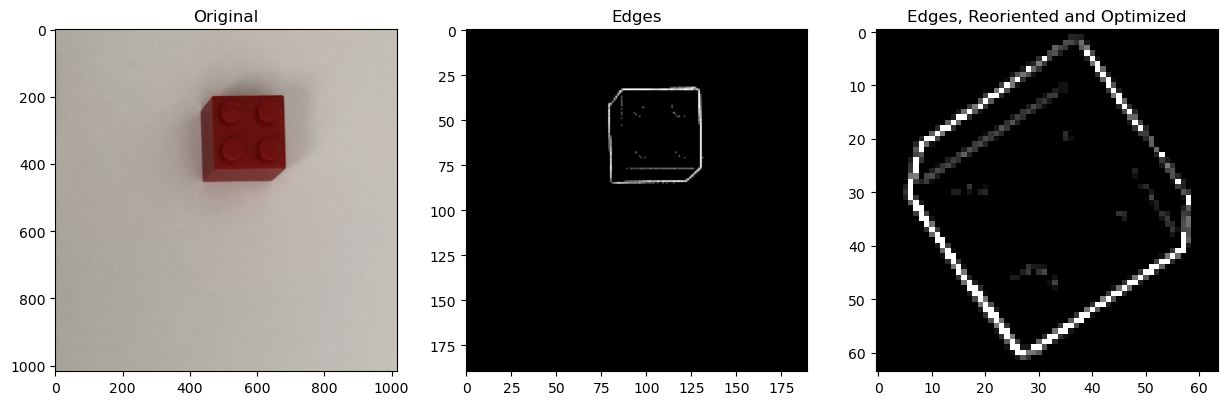

(4, 64)


In [1932]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(15)
edge_thresh = 65
neighbour_thresh = 5
idx_check = 3
class_label = 3
P = 27

im = folder_training[class_label][idx_check]
axs[0].imshow(mpimg.imread(im))
axs[0].set_title('Original')


image_array = (x_train[idx_check + P*class_label,:]-np.min(x_train[idx_check + P*class_label,:]))* 255/(np.max(x_train[idx_check + P*class_label,:])-np.min(x_train[idx_check + P*class_label,:]))

# find edges using edge filter
edges_array_scaled = get_edge(image_array, edge_thresh)
axs[1].imshow(edges_array_scaled, cmap = 'gray')
axs[1].set_title("Edges")

# clean up from noise and make a square bounding box
edges_array_scaled = clean_up(edges_array_scaled, neighbour_thresh)
edges_array_scaled = crop(edges_array_scaled)


# Reorient
edges_array_scaled = reorient(edges_array_scaled)

# increase saturation
edges_array_scaled = np.array(Image.fromarray(edges_array_scaled).resize((64,64)))
edges_array_scaled[edges_array_scaled/255 > 0.5] = 255
edges_array_scaled[edges_array_scaled/255 < 0.05] = 0
axs[2].imshow(edges_array_scaled, cmap = 'gray')
axs[2].set_title("Edges, Reoriented and Optimized")
plt.show()

# get edge histograms for different angles
edge_angles = count_edge(edges_array_scaled, 250)
hist_norm = edge_histogram1(edge_angles)
print(hist_norm.shape)

hist_norm = hist_norm.T
C = PCA(1)
a = C.fit_transform(hist_norm)
a = a.flatten()


In [1916]:
print(len(edges_array_scaled[:,0]))
print(len(edges_array_scaled[0,:]))

130
48


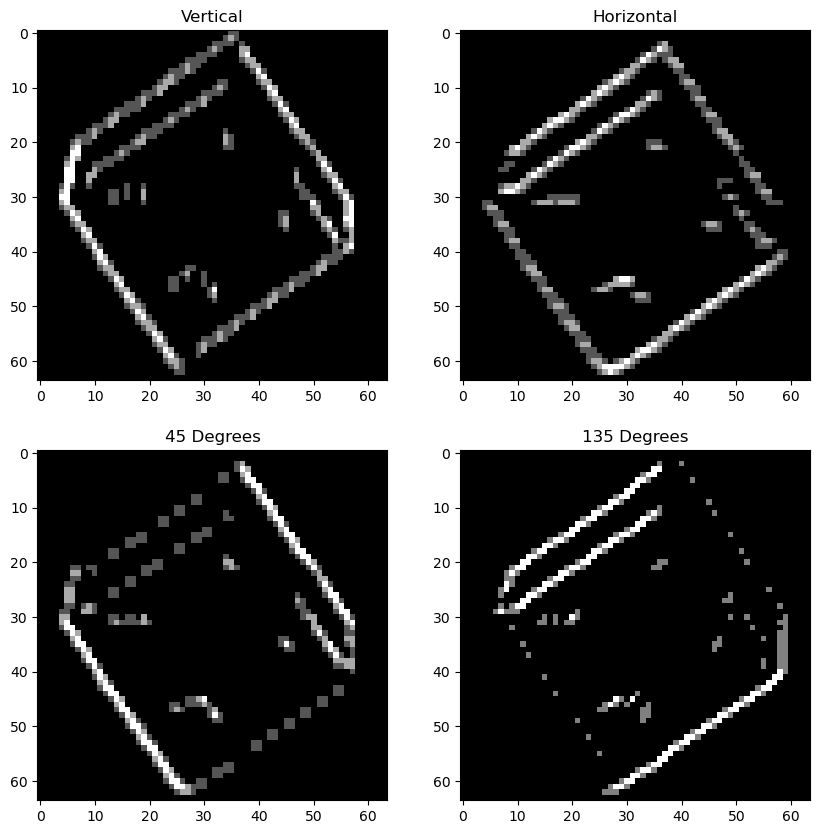

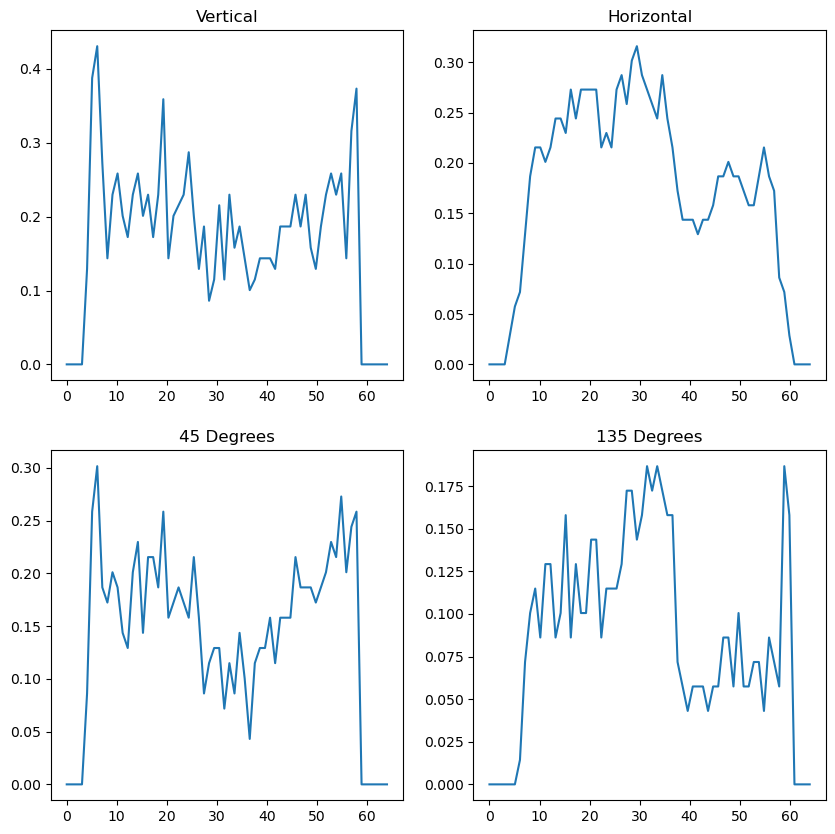

In [1937]:
fig, axs = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)

axs[0,0].imshow(edge_angles[0], cmap = 'gray')
axs[0,0].set_title("Vertical")

axs[0,1].imshow(edge_angles[1], cmap = 'gray')
axs[0,1].set_title("Horizontal")

axs[1,0].imshow(edge_angles[2], cmap = 'gray')
axs[1,0].set_title("45 Degrees")

axs[1,1].imshow(edge_angles[3], cmap = 'gray')
axs[1,1].set_title("135 Degrees")
plt.show()

fig, axs = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)
pixel = np.linspace(0,64,64)
hist_to_plot = hist_norm.T
axs[0,0].plot(pixel, hist_to_plot[0])
axs[0,0].set_title("Vertical")

axs[0,1].plot(pixel, hist_to_plot[1])
axs[0,1].set_title("Horizontal")

axs[1,0].plot(pixel, hist_to_plot[2])
axs[1,0].set_title("45 Degrees")

axs[1,1].plot(pixel, hist_to_plot[3])
axs[1,1].set_title("135 Degrees")
plt.show()

Define function "process_image":

In [1934]:
def process_image(image_array, edge_thresh, neighbour_thresh, angle_thresh):
    # increase contrast by making image occupy the whole grayscale 0 to 255
    image_array = (image_array-np.min(image_array))* 255/(np.max(image_array)-np.min(image_array))

    # find edges using edge filter
    edges_array_scaled = get_edge(image_array, edge_thresh)

    # clean up from noise and make a square bounding box
    edges_array_scaled = clean_up(edges_array_scaled, neighbour_thresh)
    edges_array_scaled = crop(edges_array_scaled)

    # Reorient
    edges_array_scaled = reorient(edges_array_scaled)

    # increase saturation
    edges_array_scaled = np.array(Image.fromarray(edges_array_scaled).resize((64,64)))
    edges_array_scaled[edges_array_scaled/255 > 0.5] = 255
    edges_array_scaled[edges_array_scaled/255 < 0.05] = 0

    # get edge histograms for different angles
    edge_angles = count_edge(edges_array_scaled, angle_thresh)
    hist_norm = edge_histogram1(edge_angles)

    hist_norm = hist_norm.T
    C = PCA(1)
    a = C.fit_transform(hist_norm)
    a = a.flatten()
    
    return a


In [1680]:
# store array of directories to each image sorted to their defined classes in the path
folder_path = []

for i in range(len(class_type)):

    class_temp = []

    for j in os.listdir(path):
        if class_type[i] in j:
            class_temp.append(j)
            
    folder_path.append(class_temp)

for i in range(len(folder_path)):
    for j in range(len(folder_path[i])):
        folder_elem = folder_path[i][j]
        folder_path[i][j] = path + folder_elem

# prepare data for testing
P_per_class = [len(folder_path[i]) for i in range(n_classes)]
x_test = np.empty((sum(P_per_class), im_width**2))
y_test = np.empty((sum(P_per_class), 1))

for i in range(n_classes):
    x_i, y_i = get_data(folder_path[i], im_width, i, P_per_class[i])
    x_test[i*P_per_class[i]:(i+1)*P_per_class[i],:] = x_i
    y_test[i*P_per_class[i]:(i+1)*P_per_class[i],:] = y_i

In [1935]:
ET = 65
NT = 5
AT = 250
# get features from training set
edge_features_train = np.empty((sum(P_per_class), 64))
for i in range(sum(P_per_class)):
    edge_features_train[i,:] = process_image(x_train[i,:], ET, NT, AT)


# get features from test set
edge_features_test = np.empty((sum(P_per_class), 64))
for i in range(sum(P_per_class)):
    edge_features_test[i,:] = process_image(x_test[i,:], ET, NT, AT)


In [1936]:
# train model and test
model = LogisticRegression()
model.fit(edge_features_train, y_train.flatten())
y_pred = model.predict(edge_features_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5370370370370371
[[13  5  8  1]
 [ 4 12  0 11]
 [ 4  2 18  3]
 [ 1  5  6 15]]


In [1853]:
def test_thresh(AT):
    ET = 65
    NT = 5
    
    # get features from training set
    edge_features_train = np.empty((sum(P_per_class), 64))
    for i in range(sum(P_per_class)):
        edge_features_train[i,:] = process_image(x_train[i,:], ET, NT, AT)


    # get features from test set
    edge_features_test = np.empty((sum(P_per_class), 64))
    for i in range(sum(P_per_class)):
        edge_features_test[i,:] = process_image(x_test[i,:], ET, NT, AT)

    # train model and test
    model = LogisticRegression()
    model.fit(edge_features_train, y_train.flatten())
    y_pred = model.predict(edge_features_test)

    return accuracy_score(y_test, y_pred)

In [1857]:
thresh = [5*i for i in range(101)]

acc = []
for i in thresh: acc.append(test_thresh(i))

print(thresh[acc.index(max(acc))])
plt.plot(thresh, acc)

260
